In [1]:
!nvidia-smi

Mon Oct 10 17:11:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         TCC  | 00000000:00:1E.0 Off |                    0 |
|  0%   22C    P8     9W / 300W |      0MiB / 22841MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import keras
# from keras import layers
from keras import backend as K
import keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
keras.__version__

'2.7.0'

# Load captured images for 3D imaging demonstration

In [3]:
from scipy.io import loadmat
datav1 = loadmat("datasets//vdata_lineoftoys.mat")
# import h5py
# datav1 = h5py.File('datav7.mat')
# import mat73
# datav1 = mat73.loadmat('datav7_2.mat')
Xvr = datav1['Xvr']
Xvr = Xvr.astype('float32')
# Xvr = np.expand_dims(Xvr,0)
Xvr = np.expand_dims(Xvr,3)
Xvg = datav1['Xvg']
Xvg = Xvg.astype('float32')
# Xvg = np.expand_dims(Xvg,0)
Xvg = np.expand_dims(Xvg,3)
Xvb = datav1['Xvb']
Xvb = Xvb.astype('float32')
# Xvb = np.expand_dims(Xvb,0)
Xvb = np.expand_dims(Xvb,3)
pid=0
rawr=Xvr[pid]
rawr=np.expand_dims(rawr,0)
rawg=Xvg[pid]
rawg=np.expand_dims(rawg,0)
rawb=Xvb[pid]
rawb=np.expand_dims(rawb,0)

In [28]:
Xvr.shape

(5, 1376, 2064, 1)

Text(0.5, 1.0, 'measured image')

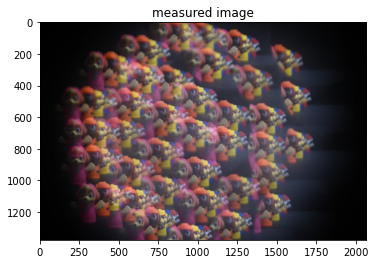

In [30]:
plt.imshow(np.concatenate((Xvr[0],Xvg[0],Xvb[0]),axis=2))
plt.title('measured image')

# Load saved models

In [21]:
from models import *
from utils import *

In [22]:
reconM1 = keras.models.load_model('reconM_1.h5', custom_objects = {'Hadamard': Hadamard})
reconM2 = keras.models.load_model('reconM_2.h5', custom_objects = {'Hadamard': Hadamard})
reconM3 = keras.models.load_model('reconM_3.h5', custom_objects = {'Hadamard': Hadamard})
reconM4 = keras.models.load_model('reconM_4.h5', custom_objects = {'Hadamard': Hadamard})
reconM5 = keras.models.load_model('reconM_5.h5', custom_objects = {'Hadamard': Hadamard})
reconM6 = keras.models.load_model('reconM_6.h5', custom_objects = {'Hadamard': Hadamard})
reconM7 = keras.models.load_model('reconM_7.h5', custom_objects = {'Hadamard': Hadamard})
reconM8 = keras.models.load_model('reconM_8.h5', custom_objects = {'Hadamard': Hadamard})
reconM9 = keras.models.load_model('reconM_9.h5', custom_objects = {'Hadamard': Hadamard})
reconM10 = keras.models.load_model('reconM_10.h5', custom_objects = {'Hadamard': Hadamard})
reconM11 = keras.models.load_model('reconM_11.h5', custom_objects = {'Hadamard': Hadamard})
reconM12 = keras.models.load_model('reconM_12.h5', custom_objects = {'Hadamard': Hadamard})
reconM13 = keras.models.load_model('reconM_13.h5', custom_objects = {'Hadamard': Hadamard})
reconM14 = keras.models.load_model('reconM_14.h5', custom_objects = {'Hadamard': Hadamard})

In [23]:
fullgenerator = keras.models.load_model('fullgenerator.h5', custom_objects = {'Hadamard': Hadamard,'custom_objective': custom_objective})

In [24]:
ds1 = 300
ds2 = 300
tsize = 256
enhanceM = enhanceModule(ds1,ds2,tsize)
enhanceM.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                            

In [25]:
# assign weights from pre-trained enhancement module
for lid in range(12,len(fullgenerator.layers)):
    weights = fullgenerator.layers[lid].get_weights()
    enhanceM.layers[lid-6].set_weights(weights)

# Reconstruction and enhancement at trained distances

In [26]:
reconMlist = [reconM1,reconM2,reconM3,reconM4,reconM5,reconM6,reconM7,reconM8,reconM9,reconM10,reconM11,reconM12,reconM13,reconM14]
recon_stack = np.zeros((15,ds1,ds2,3))
generated_stack = np.zeros((15,tsize,tsize,3))
# generated_stack3 = np.zeros((15,256,256,3))
ofs = loadmat("datasets//ofs.mat")
ofx = ofs['ofx']
ofy = ofs['ofy']
# ofx = np.ndarray.tolist(ofx)
# ofy = np.ndarray.tolist(ofy)
tcenter1 = 730
tcenter2 = 930
lid=6
for rid in range(0,14):
    temp = reconout(reconMlist[rid],ofx[rid],ofy[rid],tcenter1,tcenter2,lid,rawr,rawg,rawb)
    recon_stack[rid] = temp
    inr = temp[:,:,0]
    inr = np.expand_dims(inr,0)
    inr = np.expand_dims(inr,3)
    ing = temp[:,:,1]
    ing = np.expand_dims(ing,0)
    ing = np.expand_dims(ing,3)
    inb = temp[:,:,2]
    inb = np.expand_dims(inb,0)
    inb = np.expand_dims(inb,3)
    generated_stack[rid] = generatorout(enhanceM,inr,ing,inb)

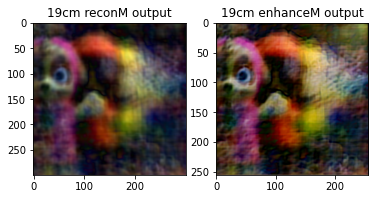

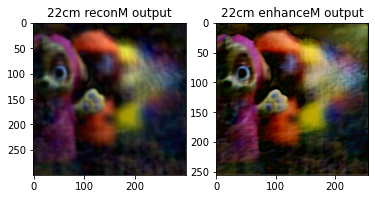

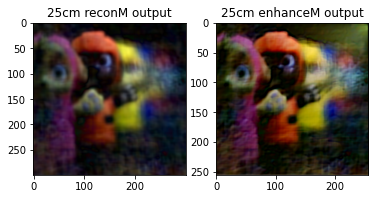

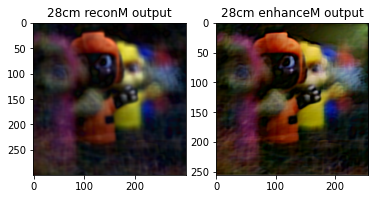

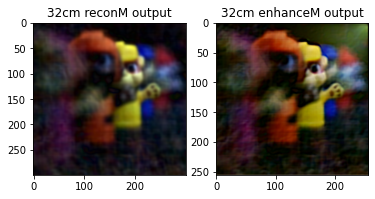

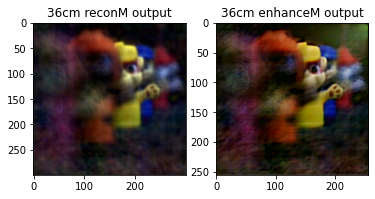

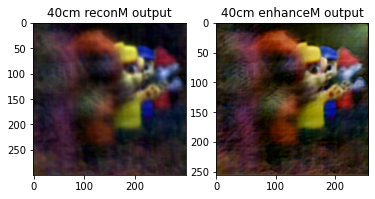

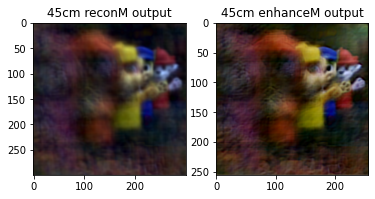

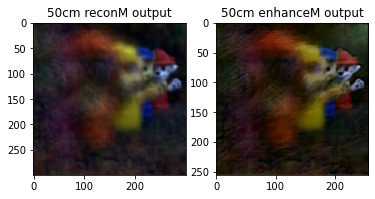

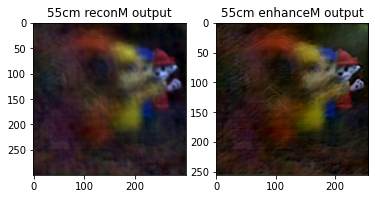

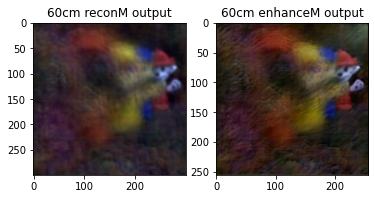

In [71]:
disd=[19,22,25,28,32,36,40,45,50,55,60]
for rid in range(0,11):
#     f, ax = plt.subplots(1, 2, figsize=(15,15))
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon_stack[rid+3])
    plt.title(str(disd[rid])+'cm reconM output')
    plt.subplot(1,2,2)
    plt.imshow(generated_stack[rid+3])
    plt.title(str(disd[rid])+'cm enhanceM output')

# Load captured images for see-through target demonstration

In [72]:
from scipy.io import loadmat
datav1=loadmat("datasets//vdata_seethrough.mat")
# import h5py
# datav1 = h5py.File('datav7.mat')
# import mat73
# datav1 = mat73.loadmat('datav7_2.mat')
Xvr=datav1['Xvr']
Xvr=Xvr.astype('float32')
# Xvr=np.expand_dims(Xvr,0)
Xvr=np.expand_dims(Xvr,3)
Xvg=datav1['Xvg']
Xvg=Xvg.astype('float32')
# Xvg=np.expand_dims(Xvg,0)
Xvg=np.expand_dims(Xvg,3)
Xvb=datav1['Xvb']
Xvb=Xvb.astype('float32')
# Xvb=np.expand_dims(Xvb,0)
Xvb=np.expand_dims(Xvb,3)
pid=0
rawr=Xvr[pid]
rawr=np.expand_dims(rawr,0)
rawg=Xvg[pid]
rawg=np.expand_dims(rawg,0)
rawb=Xvb[pid]
rawb=np.expand_dims(rawb,0)

Text(0.5, 1.0, 'measured image')

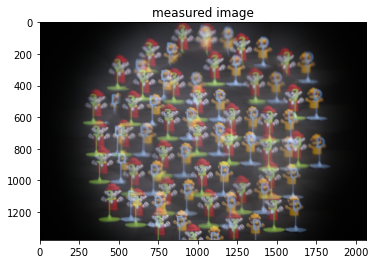

In [73]:
plt.imshow(np.concatenate((Xvr[0],Xvg[0],Xvb[0]),axis=2))
plt.title('measured image')

In [76]:
reconMlist = [reconM1,reconM2,reconM3,reconM4,reconM5,reconM6,reconM7,reconM8,reconM9,reconM10,reconM11,reconM12,reconM13,reconM14]
recon_stack = np.zeros((15,ds1,ds2,3))
generated_stack = np.zeros((15,tsize,tsize,3))
# generated_stack3 = np.zeros((15,256,256,3))
ofs = loadmat("datasets//ofs.mat")
ofx = ofs['ofx']
ofy = ofs['ofy']
# ofx = np.ndarray.tolist(ofx)
# ofy = np.ndarray.tolist(ofy)
tcenter1 = 730
tcenter2 = 1010
lid=6
for rid in range(0,14):
    temp = reconout(reconMlist[rid],ofx[rid],ofy[rid],tcenter1,tcenter2,lid,rawr,rawg,rawb)
    recon_stack[rid] = temp
    inr = temp[:,:,0]
    inr = np.expand_dims(inr,0)
    inr = np.expand_dims(inr,3)
    ing = temp[:,:,1]
    ing = np.expand_dims(ing,0)
    ing = np.expand_dims(ing,3)
    inb = temp[:,:,2]
    inb = np.expand_dims(inb,0)
    inb = np.expand_dims(inb,3)
    generated_stack[rid] = generatorout(enhanceM,inr,ing,inb)

Text(0.5, 1.0, '45 cm enhanceM output')

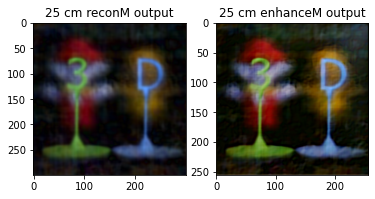

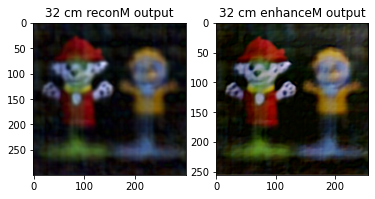

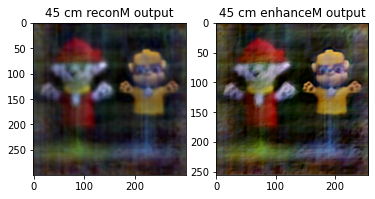

In [77]:
disd=[10,13,16,19,22,25,28,32,36,40,45,50,55,60]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(recon_stack[5])
plt.title('25 cm reconM output')
plt.subplot(1,2,2)
plt.imshow(generated_stack[5])
plt.title('25 cm enhanceM output')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(recon_stack[7])
plt.title('32 cm reconM output')
plt.subplot(1,2,2)
plt.imshow(generated_stack[7])
plt.title('32 cm enhanceM output')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(recon_stack[10])
plt.title('45 cm reconM output')
plt.subplot(1,2,2)
plt.imshow(generated_stack[10])
plt.title('45 cm enhanceM output')